# Install Independences

In [2]:
# Import os to navigate into directory
import os
# Import cv2 to manipulate the img
import cv2
# Import imghdr to see the type of img
import imghdr #
# Import matplotlib to visualize the img
import matplotlib.pyplot as plt
# Import numpy to manipulate array
import numpy as np
import random, shutil
import pydot #
import graphviz #

C:\Users\chris\AppData\Local\Temp\ipykernel_13820\863090557.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr #


In [3]:
# Import tensorflow to construct the neural network
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout #
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #
from keras.regularizers import l2
from keras import applications #
from keras.utils import plot_model #
from keras.preprocessing import image #
from keras.models import load_model #

import visualkeras

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# Pre-Processing Data: Splitting 

In [6]:
def create_ValidationSet(data_path):
    #creating test dataset from the train dataset
    dir_path=data_path
    classes = os.listdir(dir_path)
    
    # creating train directory 
    train_dir = data_path+"/Pokemon_train"
    os.system("mkdir " +train_dir)

    #moving all folders from root folder to train folder
    os.sytem("mv " + dir_path+"/* " + train_dir)

    val_dir = data_path+"/Pokemon_validation"
    os.system("mkdir " +val_dir)

    #copying all train data to test folder, in order to get same folder structure
    os.system("cp -r "+ train_dir+ "/*" + val_dir)
    #deleting images from sub directories of test folder
    os.system("find " + val_dir + "/ -name '*.*' -type f -delete")

    return "Done we split the dataset into training set and validation set"

In [7]:
# Copying 15 random images from train folders to test folders
def prep_test_data(pokemon, train_dir, test_dir):
  pop = os.listdir(train_dir+'/'+pokemon)
  test_data=random.sample(pop, 15)
  for f in test_data:
    shutil.copy(train_dir+'/'+pokemon+'/'+f, test_dir+'/'+pokemon+'/')

def loop_prep(train_dir, test_dir):
  #performing samething for each folder in train folder
  for poke in os.listdir(train_dir):
    prep_test_data(poke, train_dir, test_dir)

In [8]:
# UN ALTRO MODO è FARE LO SPLITTING DEL 20%
def create_path(path):
  train_dir = path+"/Pokemon_train"
  test_dir =  path+"/Pokemon_test"
  os.system("mkdir " +train_dir)
  os.system("mkdir " +test_dir)
  return train_dir, test_dir

def splitting(data_path, train_path, test_path, perc):
  
  # folders Pokemon
  fold = sorted(os.listdir(data_path))
  for f in fold:
    # Take the pokemon directory by data_path
    pok_dir = data_path+ f + '/'

    # CREATE POKEMON FOLDER IN THE TEST SET
    if not os.path.isdir(test_path+f):
      os.makedirs(test_path+f)
    pok_file = os.listdir(data_path+f) # list with image of pokemon
  
    # Number of pokemon for the test set
    num_test = round(len(pok_file)* perc)
    # select randomly the image of pokemon for the test set
    img_pok_test = random.sample(pok_file, num_test)

    # We move the image into test set
    for pok_test in img_pok_test:
      shutil.move(pok_dir + pok_test, test_path + f + '/'+ pok_test )

    # CREATE POKEMON FOLDER IN THE TRAIN SET
    if not os.path.isdir(train_path+f):
      os.makedirs(train_path+f)
    
    pok_file = os.listdir(data_path+f) # list with image of pokemon
    # We move the remaining image into train set
    for pok_train in pok_file:
      shutil.move(pok_dir+ pok_train, train_path+f+'/'+pok_train)
      
  return  "Done we split the dataset into training set and validation set"


# DataLoader

In [9]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           )
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb'
                                         )
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb'
                                           )
    return training_set, validation_set

## Visualize Image

In [10]:
def vis_img(train_generator):
    for each in train_generator:
        img , label = each
        train_batch = each[0]
        labels= each[1]
        break

    plt.imshow(train_batch[0])
    plt.title(np.argmax(labels[0]))

# Auxiliary Functions

## Training

In [11]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt],
                                      epochs = num_epochs )
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt],
                                      epochs = num_epochs)
    return history, filepath, es

## Accuracy and Loss Functions

In [12]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    

## Make Prediction

In [13]:
def make_prediction(model,
                    train_set, 
                    scale,
                    test_file):
    diz={v:k for k,v in train_set.class_indices.items()}

    test_img = cv2.imread(test_file)
    test_img = cv2.resize(test_img, scale)
    test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)

    #test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img/255
    #plt.imshow(test_img)

    prediction_prob = model.predict(test_img)
    classes_x=np.argmax(prediction_prob,axis=1)
    plt.title(diz[classes_x[0]])

# Model 1

Image with 64 x 64 x 3 

In [14]:
#defining model
def cnn(image_size, num_classes):
    # Reset sezione
    tf.keras.backend.clear_session()
    tf.keras.backend.reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier


In [15]:
train_dir = '/Users/leonardvincentramil/Desktop/Project/Pokemon5/PokemonData/Pokemon_train'
test_dir = '/Users/leonardvincentramil/Desktop/Project/Pokemon5/PokemonData/Pokemon_validation'
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 149

In [16]:
neuralnetwork_cnn = cnn(img_size1, num_classes= 149)
neuralnetwork_cnn.summary()
# Visualizzazione modello Baseline
tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 149)               4

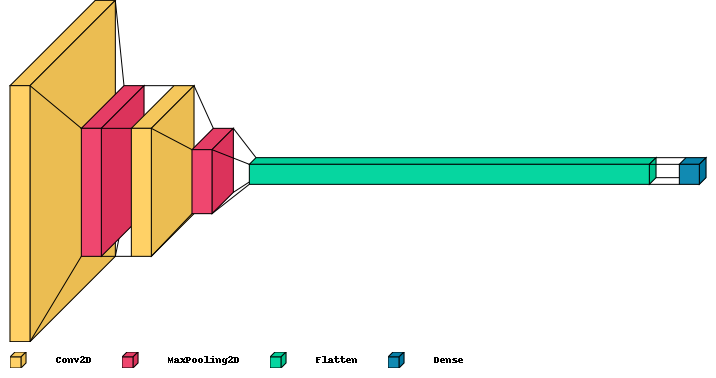

In [17]:
visualkeras.layered_view(neuralnetwork_cnn, legend = True, spacing = 30)

In [19]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size1,
                                num_batch= batch_siz1)

------ Loading TRAIN SET -------


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/leonardvincentramil/Desktop/Project/Pokemon5/PokemonData/Pokemon_train'

In [34]:
hist1 , fil1, es1 = train_model(model=neuralnetwork_cnn, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=1, 
                                num_epochs= 20) # meglio che arrivi a 20

Epoch 1/20


/var/folders/m9/pqjzxxq91zq6tyyywn2gnx740000gn/T/ipykernel_14644/256571734.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


211/212 [============================>.] - ETA: 0s - loss: 4.4813 - acc: 0.0725
Epoch 1: loss improved from inf to 4.47690, saving model to model1.h5
212/212 [==============================] - 20s 93ms/step - loss: 4.4769 - acc: 0.0730 - val_loss: 3.2772 - val_acc: 0.2734
Epoch 2/20
212/212 [==============================] - ETA: 0s - loss: 2.9172 - acc: 0.3231
Epoch 2: loss improved from 4.47690 to 2.91722, saving model to model1.h5
212/212 [==============================] - 20s 92ms/step - loss: 2.9172 - acc: 0.3231 - val_loss: 2.2361 - val_acc: 0.4630
Epoch 3/20
212/212 [==============================] - ETA: 0s - loss: 2.1658 - acc: 0.4775
Epoch 3: loss improved from 2.91722 to 2.16579, saving model to model1.h5
212/212 [==============================] - 20s 93ms/step - loss: 2.1658 - acc: 0.4775 - val_loss: 1.7260 - val_acc: 0.5917
Epoch 4/20
212/212 [==============================] - ETA: 0s - loss: 1.6792 - acc: 0.5818
Epoch 4: loss improved from 2.16579 to 1.67922, saving model

In [23]:
fil1

'model1.h5'

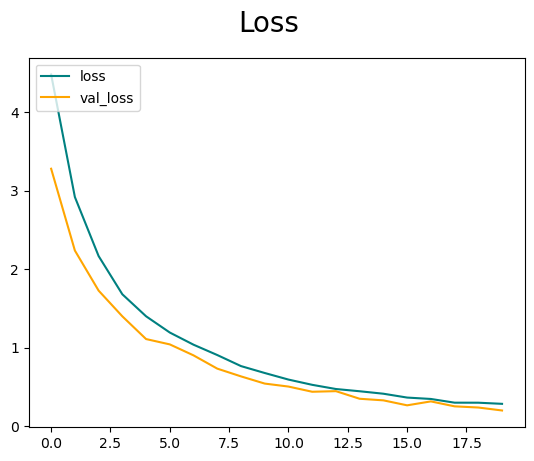

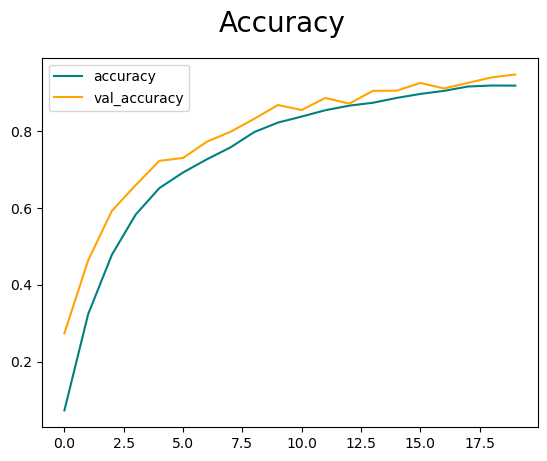

In [35]:
plot_history(hist=hist1)

1/1 [==============================] - 0s 26ms/step


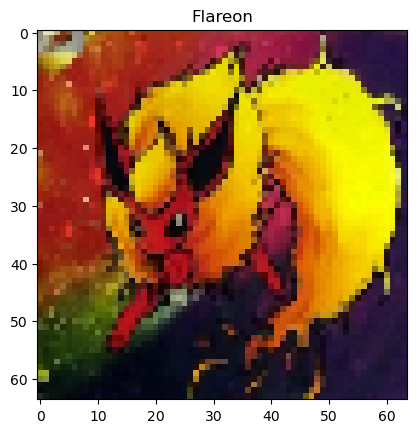

In [37]:
make_prediction(model= neuralnetwork_cnn,
                train_set = train_set1, 
                scale= (64,64),
                test_file= '/Users/leonardvincentramil/Desktop/Screenshot 2023-08-12 alle 18.26.52.png')

# Model 2

In [28]:
img_size2 = (128, 128, 3)
batch_siz2 = 32
num_classes = 149

In [29]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6779 images belonging to 149 classes.


------ Loading VALIDATION SET ------
Found 2231 images belonging to 149 classes.


In [30]:
#Defining model
def cnn2(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier

neuralnetwork_cnn2 = cnn2(img_size2, num_classes= 149)
neuralnetwork_cnn2.summary()
#plot_model(neuralnetwork_cnn2, show_shapes=True) # just learned this nice new thing

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 128)     

In [31]:
hist2 , fil2, es2 = train_model(model=neuralnetwork_cnn2, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=2, 
                                num_epochs= 50)

Epoch 1/50


/var/folders/m9/pqjzxxq91zq6tyyywn2gnx740000gn/T/ipykernel_12686/256571734.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


212/212 [==============================] - ETA: 0s - loss: 4.4547 - acc: 0.0761
Epoch 1: loss improved from inf to 4.45471, saving model to model2.h5
212/212 [==============================] - 37s 169ms/step - loss: 4.4547 - acc: 0.0761 - val_loss: 3.3157 - val_acc: 0.2488
Epoch 2/50
212/212 [==============================] - ETA: 0s - loss: 2.9046 - acc: 0.3192
Epoch 2: loss improved from 4.45471 to 2.90460, saving model to model2.h5
212/212 [==============================] - 35s 165ms/step - loss: 2.9046 - acc: 0.3192 - val_loss: 2.2257 - val_acc: 0.4666
Epoch 3/50
212/212 [==============================] - ETA: 0s - loss: 2.1226 - acc: 0.4802
Epoch 3: loss improved from 2.90460 to 2.12261, saving model to model2.h5
212/212 [==============================] - 35s 166ms/step - loss: 2.1226 - acc: 0.4802 - val_loss: 1.6215 - val_acc: 0.5957
Epoch 4/50
212/212 [==============================] - ETA: 0s - loss: 1.6114 - acc: 0.5908
Epoch 4: loss improved from 2.12261 to 1.61143, saving mo

1/1 [==============================] - 0s 16ms/step


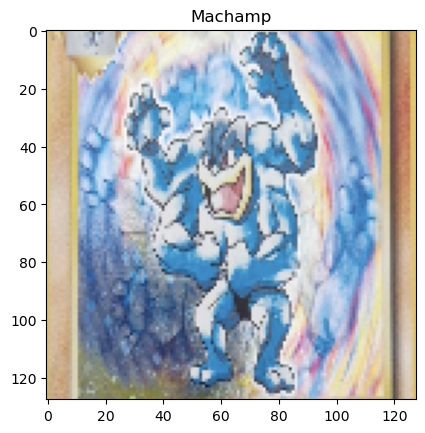

In [41]:
make_prediction(model= neuralnetwork_cnn2,
                train_set = train_set2, 
                scale= (128,128),
                test_file= '/Users/leonardvincentramil/Downloads/Machamp.jpg')